# Filtering out 'stringy' molecules

In [1]:
import os
import rdkit
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.rdMolDescriptors import CalcNumRings
from rdkit.Chem import rdmolops, AllChem, Draw

First, let's visualise an example 'stringy' molecule that I want to rule out.

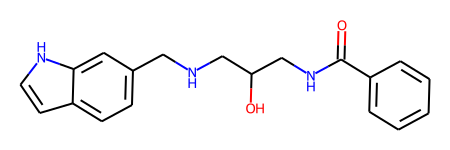

In [2]:
sdf_file = 'example_mols.sdf'
mols = [m for m in Chem.SDMolSupplier(sdf_file)]
for m in mols:
    _ = AllChem.Compute2DCoords(m)

mols[0]

Now, I'll introduce the filtering steps used to identify these. I want to remove molecules that have long 'linker' regions (i.e. substructures that join together two rings) and long 'sidechains' (i.e. substructures that are joined to only one ring). I want to set different thresholds for the two, denoting the max length to be tolerated of these substructures.

There are several useful functions involved for manipulating bonds and rings in this code, which include the following.

- **Chem.Mol.getRingInfo()**
    - Stores information about the rings in a molecule
    - We can then use Chem.Mol.getRingInfo().BondRings() to pull out the indices of all bonds that are part of rings. 
- **Chem.Bond.GetBeginAtomIdx()** and **Chem.Bond.GetEndAtomIdx()**
    - Useful for pulling out the atoms that are attached to a specific bond you're interested in
- **Chem.Bond.GetBondTypeAsDouble()**
    - For determining whether a bond is a single, aromatic or double bond
- **Chem.FragmentOnBonds()**
    - For fragmenting a molecule at the bonds that you specify (use together with Chem.GetMolFrags())
- **Chem.rdmolops.FindAllPathsOfLengthN()**
    - Finds all paths up to a certain length within your molecule or substructure (and so is useful for filtering out those of a certain length)

First, we fragment the molecule into rings and linkers (using very helpful code from https://iwatobipen.wordpress.com/2020/01/23/cut-molecule-to-ring-and-linker-with-rdkit-rdkit-chemoinformatics-memo/).

In [3]:
def is_in_same_ring(idx1, idx2, bond_rings):
    """
    Checks whether two atoms on either side of a bond are in the same ring.
    """
    for bond_ring in bond_rings:
        if idx1 in bond_ring and idx2 in bond_ring:
            return True
    return False


def get_linker_bonds(mol, useScaffold=False):
    """
    Returns the bonds that attach rings to the linkers.
    """
    res = []
    
    # set the original atom and bond indices as properties
    for atom in mol.GetAtoms():
        atom.SetIntProp("orig_idx", atom.GetIdx())
    for bond in mol.GetBonds():
        bond.SetIntProp("orig_idx", bond.GetIdx())

    if useScaffold:
        mol = MurckoScaffold.GetScaffoldForMol(mol)
    
    
    # get the indices of bonds that belong to rings
    ring_info = mol.GetRingInfo()
    bond_rings = ring_info.BondRings()
    ring_bonds = set()
    for ring_bond_idxs in bond_rings:
        for idx in ring_bond_idxs:
            ring_bonds.add(idx)
            
    # get the indices of all bonds in the molecule and which don't belong to rings
    all_bonds_idx = [bond.GetIdx() for bond in mol.GetBonds()]
    none_ring_bonds = set(all_bonds_idx) - ring_bonds
    
    # for each non-ring bond, determine if the bond attaches a 'linker' to a ring
    for bond_idx in none_ring_bonds:
        # get the atoms on either sides of the bond
        bgn_idx = mol.GetBondWithIdx(bond_idx).GetBeginAtomIdx()
        end_idx = mol.GetBondWithIdx(bond_idx).GetEndAtomIdx()
        
        # if a single bond, determine whether one of the atoms is part of a ring
        if mol.GetBondWithIdx(bond_idx).GetBondTypeAsDouble() == 1.0:
            if mol.GetAtomWithIdx(bgn_idx).IsInRing()+mol.GetAtomWithIdx(end_idx).IsInRing() == 1:
                bond = mol.GetBondWithIdx(bond_idx)
                orig_idx = bond.GetIntProp("orig_idx")
                res.append(orig_idx)

            # check whether the atoms on either side of the bond are attached to two different rings (short linker)
            elif not is_in_same_ring(bgn_idx, end_idx, bond_rings) and mol.GetAtomWithIdx(bgn_idx).IsInRing()+mol.GetAtomWithIdx(end_idx).IsInRing() == 2:
                bond = mol.GetBondWithIdx(bond_idx)
                orig_idx = bond.GetIntProp("orig_idx")
                res.append(orig_idx)

    return res


def fragment_molecule(mol, bonds):
    """
    Fragments the molecule into rings, 'linkers' (attached to two rings) and 'sidechains' (attached to one ring).
    """
    frags = Chem.FragmentOnBonds(mol, bonds)
    fragments = Chem.GetMolFrags(frags, asMols=True)
    return fragments


def get_linkers_sidechains(fragments):
    """
    Check for 'linkers' or 'sidechains' by counting the number of attachment points
    """
    linkers = []
    sidechains = []
    
    for fragment in fragments:
        numRings = CalcNumRings(fragment)
        if numRings == 0:
            smiles = Chem.MolToSmiles(fragment)
            # if one attachment point, this is a 'linker'
            if smiles.count('*') == 1:
                sidechains.append(fragment)
            else:
                linkers.append(fragment)

    return linkers, sidechains

Let's see what this looks like for the example molecule above.

Linker bonds: [8, 17]


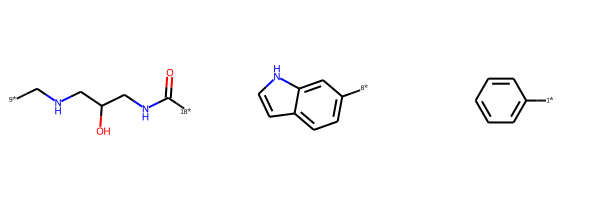

In [4]:
example_mol = mols[0]
linker_bonds = get_linker_bonds(example_mol)
print("Linker bonds:", linker_bonds)

fragments = fragment_molecule(example_mol, linker_bonds)
for f in fragments:
    _ = AllChem.Compute2DCoords(f)
Draw.MolsToGridImage(fragments, subImgSize=(200,200))

# linkers: 1
# sidechains: 0


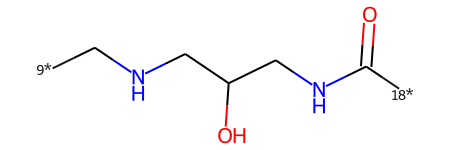

In [5]:
linkers, sidechains = get_linkers_sidechains(fragments)
print('# linkers:', len(linkers))
print('# sidechains:', len(sidechains))

linker = linkers[0]
linker

We then count the max path of the non-ring substructures and use this to filter out molecules with many consecutive non-ring atoms.

In [6]:
def max_path(fragment):
    """
    Returns the path length of the substructure.
    """
    maxPath = 0
    numAtoms = fragment.GetNumHeavyAtoms()
    # look for paths up the length of number of atoms
    for i in range(numAtoms):
        # get max consecutive path length in linker
        paths = rdmolops.FindAllPathsOfLengthN(fragment, i, useBonds=True)
        if len(paths) > 0:
            maxPath = i

    return maxPath

In [7]:
print('Path length of linker:', max_path(linker))

Path length of linker: 8


In [8]:
def apply_filter(mol, linkerPathThreshold=8, sidechainPathThreshold=6, useScaffold=False):
    """
    Filters out molecules depending on the max 'linker' and 'sidechain' length (i.e. max number of consecutive non-ring atoms)
    """
    linker_bonds = get_linker_bonds(mol, useScaffold)

    if len(linker_bonds) == 0:
        return 'pass'

    else:
        fragments = fragment_molecule(mol, linker_bonds)
        linkers, sidechains = get_linkers_sidechains(fragments)

        maxLinkerPath = 0
        maxSidechainPath = 0

        if len(linkers) > 0:
            for linker in linkers:
                numLinkerAtoms = linker.GetNumHeavyAtoms()
                for i in range(numLinkerAtoms):  # look for paths up the length of number of atoms
                    # get max consecutive path length in linker
                    linkerPaths = rdmolops.FindAllPathsOfLengthN(linker, i, useBonds=True)
                    if len(linkerPaths) > 0 and i > maxLinkerPath:
                        maxLinkerPath = i

        if len(sidechains) > 0:
            for sidechain in sidechains:
                numSidechainAtoms = sidechain.GetNumHeavyAtoms()
                for i in range(numSidechainAtoms):  # look for paths up the length of number of atoms
                    # get max consecutive path length in sidechain
                    sidechainPaths = rdmolops.FindAllPathsOfLengthN(sidechain, i, useBonds=True)
                    if len(sidechainPaths) > 0 and i > maxSidechainPath:
                        maxSidechainPath = i

        if maxLinkerPath < linkerPathThreshold and maxSidechainPath < sidechainPathThreshold:
            return 'pass'

        else:
            return 'fail'

Let's apply this to some example molecules and visualise the results. Obviously this is dependent on what you want to set your threshold to be.

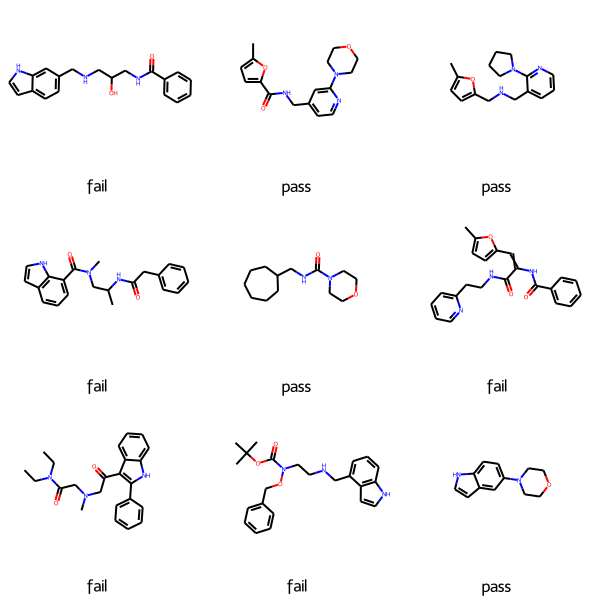

In [9]:
results = [apply_filter(mol) for mol in mols]
Draw.MolsToGridImage(mols, legends=results)